# 0. Setup

In [1]:
# ! pip install urllib3==1.26.12
! pip install urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install transformers newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import urllib3
urllib3.__version__

'1.25.11'

In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

# 0.5 General preprocessing

In [7]:
import spacy
# ! python -m spacy download en_core_web_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
import spacy

In [9]:
TARGET = 'label'
TEXT = 'text'
STOPWORDS = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

In [10]:
# Constants that will disappear when transitioning to functions:
# Cell 1
html_folder = HTML_FOLDER
# Cell 2
csv_path = 'url_classification_temporary536.csv'
usecols = ['File Name', 'Label']

In [11]:
# Important cell # 1
html_files = os.listdir(html_folder)

In [12]:
# Important cell # 2

df = pd.read_csv(csv_path, usecols=usecols)
df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
df = df[~df['filename'].isna()]
print(f'Original shape: {df.shape}')
df = df[df['label'] != '-']
df.reset_index(drop=True, inplace=True)
print(f'Final shape: {df.shape}')

Original shape: (535, 2)
Final shape: (461, 2)


In [13]:
# Important cell # 3
df[TARGET].value_counts(normalize=False)

Home Page        162
MISC              87
Blog              84
Product Page      44
Article           42
Event             15
White Paper       12
Education          6
?                  3
About Page         2
Press Release      2
Video Content      1
Publication        1
Name: label, dtype: int64

In [14]:
# Important cell # 4
filenames = df['filename'].values
htmls = list()

for i, filename in enumerate(filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
      html = f.read()
      htmls.append(html)
  except FileNotFoundError:
    print(f'File {i} not found: "{filename}"')

In [15]:
# Important cell # 5
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language = "en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)

In [16]:
# Important cell # 6
y = df[TARGET].tolist()

In [17]:
# Important cell # 7
summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]

In [18]:
len(y), len(summaries)

(461, 461)

In [19]:
# Cell 8
minimum_words = 30 
maximum_classes = 4

# Important cell # 8
df_text = pd.DataFrame({TEXT: summaries, TARGET: y})

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

if maximum_classes:
  relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
  df_text = df_text[df_text[TARGET].isin(relevant_labels)] # this is to erase all classes after 'maximum_classes'
  # df_text.loc[~df_text[TARGET].isin(relevant_labels), TARGET] = 'MISC' # this is to not erase them, but change their value to 'MISC'

df_text.reset_index(drop=True, inplace=True)

In [20]:
df_text[TARGET].value_counts()

Home Page       127
Blog             83
MISC             77
Product Page     44
Name: label, dtype: int64

In [21]:
df_text

,text,label
0,Write For Us. Want to Write for Us? Digital L...,MISC
1,"Write for Us. Yes, you. We’re always looking f...",MISC
2,FAQs for some new features available in the Be...,Blog
3,The Web Credibility Project. Our research in W...,Home Page
4,Model DJs for Retail. DJPeoples is the nation’...,MISC
...,...,...
326,Teach Yourself Visually Search Engine Optimiza...,Product Page
327,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
328,Submit A Guest Post – Guidelines (Write for Us...,MISC
329,Fully Managed Magento Hosting — JetRails. Full...,MISC


In [22]:
# Important cell # 8
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text

    # nlp = load_nlp()
    # text = ' '.join(token.lemma_ for token in nlp(text))

    return text

print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning text: 282667
Amount of unique words before cleaning text: 30719

Amount of words after cleaning text: 169218
Amount of unique words before cleaning text: 18797


In [23]:
def lemmatize_text(text):
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before lemmatizing text: 282667
Amount of unique words before lemmatizing text: 30719

Amount of words after lemmatizing text: 340736
Amount of unique words before lemmatizing text: 14356


In [24]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning lemmatized text: 340736
Amount of unique words before cleaning lemmatized text: 14356

Amount of words after cleaning lemmatized text: 158510
Amount of unique words before cleaning lemmatized text: 13580


In [25]:
df_text.head(3) # df with different techniques for preprocessing of the text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...


In [26]:
df_text.loc[0, TEXT]

'Write For Us. Want to Write for Us?  Digital Lamp, is one of the fastest-growing tech blog. We allow you an endless opportunity for new authors, technical content writers, freelance content writing professionals, and guest writers to technology + “write for us” + guest post (Contribute or Submit Guest Post Article) about the topics related to Technology, Business, Internet, Gadgets, Digital Marketing, Security, SEO, Tech Blog, etc.  Technology is the way progressive for online businesses. Why not share your expertise by guest blogging on technology blogs to highlight awareness of this emerging trend.  You will obtain the benefits of being a guest blogger by establishing yourself as an authority in the industry. On top of that, you will build social proof, create a robust online presence, develop new relationships with bloggers and readers and rank better in the search engines.  All you need to do is meet the criteria set out by the technology blogs below and submit your best work as a

In [27]:
df_text.loc[0, 'lemmatized_text']

'write for we . want to write for we ?   Digital Lamp , be one of the fast - grow tech blog . we allow you an endless opportunity for new author , technical content writer , freelance content write professional , and guest writer to technology + " write for we " + guest post ( contribute or submit Guest Post Article ) about the topic relate to Technology , Business , Internet , Gadgets , Digital Marketing , security , seo , Tech Blog , etc .   Technology be the way progressive for online business . why not share your expertise by guest blogging on technology blog to highlight awareness of this emerge trend .   you will obtain the benefit of be a guest blogger by establish yourself as an authority in the industry . on top of that , you will build social proof , create a robust online presence , develop new relationship with blogger and reader and rank well in the search engine .   all you need to do be meet the criterion set out by the technology blog below and submit your good work as 

In [28]:
df_text.loc[0, 'lemmatized_cleaned_text']

'write want write Digital Lamp one fast grow tech blog allow endless opportunity new author technical content writer freelance content write professional guest writer technology + write + guest post contribute submit Guest Post Article topic relate Technology Business Internet Gadgets Digital Marketing security seo Tech Blog etc Technology way progressive online business share expertise guest blogging technology blog highlight awareness emerge trend obtain benefit guest blogger establish authority industry top build social proof create robust online presence develop new relationship blogger reader rank well search engine need meet criterion set technology blog submit good work guest blogger guideline Write Technology Blog Content must high quality informative 100 Copyscape pass article article must english language content length minimum 1000 + word Content must well format sub heading short paragraph 2 3 line article publish Digital Lamp request removal entertain remove link request l

In [29]:
# df_text['lemmatized_text'].tolist()[10:30]

In [30]:
def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

In [31]:
def lemmatize_text2(text):
  lemmatized = ' '.join(token.text.lower() for token in nlp(text))
  return lemmatized

df_text['w2v_text'] = df_text[TEXT].apply(lemmatize_text2)

In [32]:
string = df_text.loc[0, TEXT]

In [33]:
print(f"Amount of words before tokenizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
tokenized = [word_tokenize(string) for string in df_text[TEXT]]
df_text['tokenized'] = list(map(lambda x: ' '.join(x), tokenized))
print(f"Amount of words after tokenizing text: {df_text['tokenized'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text['tokenized'].str.split().values, axis=0)).shape[0]}")

Amount of words before tokenizing text: 282667
Amount of unique words before tokenizing text: 30719

Amount of words after tokenizing text: 321805
Amount of unique words before tokenizing text: 19606


In [34]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text,tokenized
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...,Write For Us . Want to Write for Us ? Digital ...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki...","Write for Us . Yes , you . We ’ re always look..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...,FAQs for some new features available in the Be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...,The Web Credibility Project . Our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...,Model DJs for Retail . DJPeoples is the nation...
...,...,...,...,...,...,...,...
326,Teach Yourself Visually Search Engine Optimiza...,Product Page,Teach Yourself Visually Search Engine Optimiza...,teach yourself Visually Search Engine Optimiza...,teach Visually Search Engine Optimization whet...,teach yourself visually search engine optimiza...,Teach Yourself Visually Search Engine Optimiza...
327,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page,The Art SEO 2nd Edition Four acknowledged expe...,"the art of seo , 2nd Edition . four acknowledg...",art seo 2nd Edition four acknowledge expert se...,"the art of seo , 2nd edition . four acknowledg...","The Art of SEO , 2nd Edition . Four acknowledg..."
328,Submit A Guest Post – Guidelines (Write for Us...,MISC,Submit A Guest Post Guidelines Write Us We acc...,submit a Guest Post – Guidelines ( write for U...,submit Guest Post Guidelines write Us accept G...,submit a guest post – guidelines ( write for u...,Submit A Guest Post – Guidelines ( Write for U...
329,Fully Managed Magento Hosting — JetRails. Full...,MISC,Fully Managed Magento Hosting JetRails Fully M...,fully manage Magento Hosting — JetRails . full...,fully manage Magento Hosting JetRails fully ma...,fully managed magento hosting — jetrails . ful...,Fully Managed Magento Hosting — JetRails . Ful...


# 0.7 General modeling functions

In [35]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf


def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def print_confusion_matrix(y_test, y_pred, with_report=False):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {get_accuracy(y_test, y_pred):.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))


def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def create_misclassified_df(X_test, y_test, y_pred):
  df = X_test.copy()[y_pred != y_test]
  df['y_true'] = y_test[y_pred != y_test]
  df['y_pred'] = y_pred[y_pred != y_test]
  return df

# 1. Bag of Words approach

## Preprocessing

In [36]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'lemmatized_cleaned_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

In [ ]:
# def print_train_val_len_start(train_index, val_index):
#     print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
#           f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')

# def print_val_scores(scores, extra_info=False):
#     print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
#     if extra_info:
#         print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')

# print('\nStratifiedKFold:\n')
# skf = StratifiedKFold(n_splits=5)
# for train_index, val_index in skf.split(X_train, y_train):
#     print_train_val_len_start(train_index, val_index)
#     print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

# scores = cross_val_score(KNeighborsClassifier(), 
#                          X_train,
#                          y_train,
#                          cv=skf)
# print_val_scores(scores)

In [37]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy: {baseline_accuracy:.4f}')

Baseline accuracy: 0.3881


In [38]:
get_most_common_tokens(df=df_text, column='lemmatized_cleaned_text', amount=10)

[('use', 1333),
 ('content', 1247),
 ('I', 1163),
 ('post', 1096),
 ('get', 920),
 ('make', 908),
 ('search', 856),
 ('page', 839),
 ('write', 796),
 ('keyword', 785)]

In [39]:
# Important cell # 11
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [40]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((264, 193793), (67, 193793))

In [33]:
# import string

# # STOPWORDS = stop_words.ENGLISH_STOP_WORDS

# #Function for basic cleaning/preprocessing texts
# def clean(doc):
#     # Removal of punctuation marks (.,/\][{} etc) and numbers
#     doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
#     # Removal of stopwords
#     doc = " ".join([token for token in doc.split() if token not in STOPWORDS])
#     return doc.lower()

# string.punctuation

## Modeling

In [41]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    # ('KNN 7', KNeighborsClassifier(n_neighbors=7)),
    # ('KNN 12', KNeighborsClassifier(n_neighbors=12)),
    # ('KNN 20', KNeighborsClassifier(n_neighbors=20)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test) # To use when I have more data for validation set
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.656716
RandomForest        0.716418
KNN 5               0.447761
SVM C1              0.671642
MultinomialNB       0.537313
Best classifier: RandomForest, test accuracy: 0.716


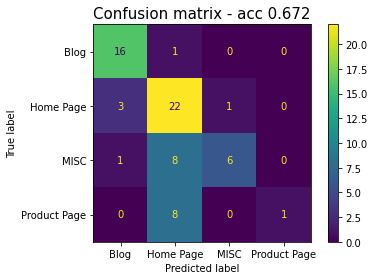


              precision    recall  f1-score   support

        Blog       0.80      0.94      0.86        17
   Home Page       0.56      0.85      0.68        26
        MISC       0.86      0.40      0.55        15
Product Page       1.00      0.11      0.20         9

    accuracy                           0.67        67
   macro avg       0.81      0.57      0.57        67
weighted avg       0.75      0.67      0.63        67



In [42]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

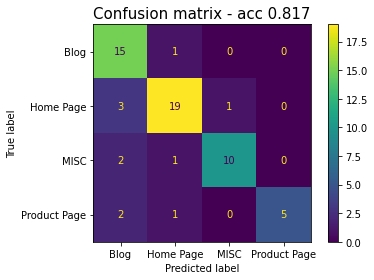


              precision    recall  f1-score   support

        Blog       0.68      0.94      0.79        16
   Home Page       0.86      0.83      0.84        23
        MISC       0.91      0.77      0.83        13
Product Page       1.00      0.62      0.77         8

    accuracy                           0.82        60
   macro avg       0.86      0.79      0.81        60
weighted avg       0.84      0.82      0.82        60



In [42]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

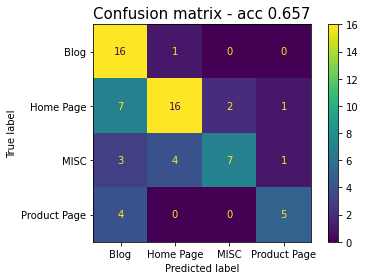


              precision    recall  f1-score   support

        Blog       0.53      0.94      0.68        17
   Home Page       0.76      0.62      0.68        26
        MISC       0.78      0.47      0.58        15
Product Page       0.71      0.56      0.63         9

    accuracy                           0.66        67
   macro avg       0.70      0.64      0.64        67
weighted avg       0.70      0.66      0.65        67



In [43]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [44]:
print_important_features(clf, features=5)

Class "Blog" - 5 most important features: ['guest' 'guest post' 'digital' 'cart' 'please']
Class "Home Page" - 5 most important features: ['write' 'content' 'post' 'link' 'article']
Class "MISC" - 5 most important features: ['search' 'product' 'customer' 'keyword' 'seo']
Class "Product Page" - 5 most important features: ['post' 'article' 'guest' 'marketing' 'blog']


In [45]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred)
misclassified_df

,lemmatized_cleaned_text,y_true,y_pred
111,Creator First Accelerator Program Clubhouse ce...,MISC,Blog
320,state brand consistency state brand consistenc...,MISC,Home Page
270,homepage Yellow Pages Emails company use Findt...,Home Page,Blog
102,write Essay Unique Features Guarantees offer m...,Product Page,Blog
58,airmail 5 Apple Design Award 2017 Winner Airma...,Product Page,Blog
184,Content Strategy Enterprise Marketers Content ...,Home Page,Blog
243,Ecommerce definition Examples Origin Online Sh...,MISC,Blog
43,Site Explorer Ahrefs competitive Analysis Tool...,Product Page,Blog
218,Adobe Commerce Developer Guide Adobe Commerce ...,Home Page,Product Page
263,Fearlessflyercom interested writing fuel artic...,Home Page,MISC


# 2. Word2Vec approach

In [45]:
# Deleting heavy variables no longer useful:
del X_train_tr
del X_test_tr

In [46]:
from gensim.models import Word2Vec, KeyedVectors

In [47]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [48]:
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)

In [49]:
w2v_model.word_vec("test").shape

(300,)

In [50]:
print("Shape of embedding vector", w2v_model["Natural"].shape)
print("First 20 numbers in the embedding of the word Natural\n\n", w2v_model["Natural"][:20])

Shape of embedding vector (300,)
First 20 numbers in the embedding of the word Natural

 [-0.22753906 -0.07617188 -0.06787109 -0.1015625   0.20214844  0.12890625
  0.1796875  -0.11035156  0.01123047  0.01794434  0.12402344  0.11132812
 -0.3359375  -0.01104736 -0.16015625 -0.16113281 -0.13769531  0.4296875
 -0.03979492  0.05297852]


In [79]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,text_lemma
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...
293,Geniuz Media. The USPS is undoubtedly one of t...,Home Page,Geniuz Media The USPS undoubtedly one best cou...,Geniuz Media . the USPS be undoubtedly one of ...,Geniuz Media USPS undoubtedly one good courier...,geniuz media . the usps is undoubtedly one of ...
294,Submit Guest Post. Yes! We accept guest/Sponso...,MISC,Submit Guest Post Yes We accept guest Sponsore...,submit Guest Post . yes ! we accept guest / sp...,submit Guest Post yes accept guest sponsor pos...,submit guest post . yes ! we accept guest / sp...
295,Digital Marketing & Entrepreneurship Blog. Why...,MISC,Digital Marketing Entrepreneurship Blog Why wo...,Digital Marketing & Entrepreneurship Blog . wh...,Digital Marketing Entrepreneurship Blog would ...,digital marketing & entrepreneurship blog . wh...
296,"Real Estate, Fashion, Software, Travel. Write ...",MISC,Real Estate Fashion Software Travel Write us G...,"real Estate , Fashion , Software , Travel . wr...",real Estate Fashion Software Travel write guid...,"real estate , fashion , software , travel . wr..."


In [80]:
list_of_lists = df_text['text_lemma'].str.split().tolist()

In [81]:
#Function that takes in the input text dataset in form of list of lists where each sentence is a list of words all the sentences are 
#inside a list
def embedding_feats(list_of_lists, DIMENSION, w2v_model):
    zeros_vector = np.zeros(DIMENSION)
    feats = []
    missing = set()
    missing_sentences = set()
    #Traverse over each sentence
    for tokens in tqdm(list_of_lists):
        # Initially assign zeroes as the embedding vector for the sentence
        feat_for_this = zeros_vector
        #Count the number of words in the embedding for this sentence
        count_for_this = 0
        #Traverse over each word of a sentence
        for token in tokens:
            #Check if the word is in the embedding vector
            if token in w2v_model:
                #Add the vector of the word to vector for the sentence
                feat_for_this += w2v_model[token]
                count_for_this +=1
            #Else assign the missing word to missing set just to have a look at it
            else:
                missing.add(token)
        #If no words are found in the embedding for the sentence
        if count_for_this == 0:
            #Assign all zeroes vector for that sentence
            feats.append(feat_for_this)
            #Assign the missing sentence to missing_sentences just to have a look at it
            missing_sentences.add(' '.join(tokens))
        #Else take average of the values of the embedding for each word to get the embedding of the sentence
        else:
            feats.append(feat_for_this/count_for_this)
    return feats, missing, missing_sentences

In [82]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 298/298 [00:00<00:00, 358.16it/s]


In [83]:
print("Shape of the final embeddings for the sentences", np.array(vectors).shape)
print("First 20 numbers in the embedding of the first train sentence\n\n", np.array(vectors)[0][:20])

Shape of the final embeddings for the sentences (298, 300)
First 20 numbers in the embedding of the first train sentence

 [ 0.01043723 -0.00884224  0.00654875  0.06653393 -0.05622904  0.02908419
 -0.00106272 -0.05186044  0.03571645 -0.00347303 -0.10706675 -0.08256114
  0.0127479   0.00736069 -0.11823477  0.07284687  0.09000731  0.01420004
 -0.01915573 -0.05401642]


In [84]:
len(vectors), vectors[0].shape

(298, (300,))

In [85]:
#Function for calculating roc auc with given actual binary values across target variables
#and the probability score made by the model
def accuracy(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [86]:
from statistics import mean

In [87]:
vectors, missing, missing_sentences = embedding_feats(list_of_lists, 300, w2v_model)

100%|██████████| 298/298 [00:00<00:00, 406.70it/s]


In [88]:
train_data, val_data, train_cats, val_cats = train_test_split(vectors, y, 
                                                              test_size=test_size,
                                                              stratify=y, 
                                                              random_state=random_state)

In [89]:
lr = LogisticRegression(max_iter=10000, class_weight='balanced').fit(train_data, train_cats)

In [90]:
y_vals = val_cats

In [91]:
y_preds = lr.predict(val_data)

In [92]:
y_test.value_counts() # checking how many there were before

Home Page       23
Blog            16
MISC            13
Product Page     8
Name: label, dtype: int64

In [93]:
y_vals.value_counts()

Home Page       23
Blog            16
MISC            13
Product Page     8
Name: label, dtype: int64

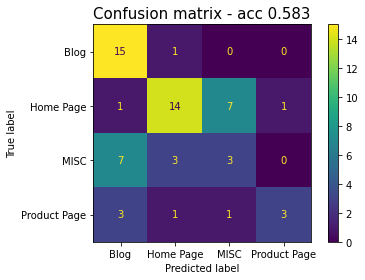

In [94]:
print_confusion_matrix(y_vals, y_preds, with_report=False)

# 3. BERT approach (anirban sen)

In [37]:
# Deleting heavy variables no longer useful:
try:
  del path, w2v_model
except NameError:
  pass

In [39]:
import urllib3
urllib3.__version__

'1.25.11'

In [42]:
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
import torch
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from torch.nn import BCEWithLogitsLoss, Sigmoid

from tqdm.notebook import tqdm, trange

# from keras.preprocessing.sequence import pad_sequences

In [47]:
df_text

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
3,The Web Credibility Project. Our research in W...,Home Page,The Web Credibility Project Our research Web c...,the web Credibility Project . our research in ...,web Credibility Project research web credibili...,the web credibility project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,Model DJs Retail DJPeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...,Model dj Retail djpeople nation premier agency...,model djs for retail . djpeoples is the nation...
...,...,...,...,...,...,...
293,Geniuz Media. The USPS is undoubtedly one of t...,Home Page,Geniuz Media The USPS undoubtedly one best cou...,Geniuz Media . the USPS be undoubtedly one of ...,Geniuz Media USPS undoubtedly one good courier...,geniuz media . the usps is undoubtedly one of ...
294,Submit Guest Post. Yes! We accept guest/Sponso...,MISC,Submit Guest Post Yes We accept guest Sponsore...,submit Guest Post . yes ! we accept guest / sp...,submit Guest Post yes accept guest sponsor pos...,submit guest post . yes ! we accept guest / sp...
295,Digital Marketing & Entrepreneurship Blog. Why...,MISC,Digital Marketing Entrepreneurship Blog Why wo...,Digital Marketing & Entrepreneurship Blog . wh...,Digital Marketing Entrepreneurship Blog would ...,digital marketing & entrepreneurship blog . wh...
296,"Real Estate, Fashion, Software, Travel. Write ...",MISC,Real Estate Fashion Software Travel Write us G...,"real Estate , Fashion , Software , Travel . wr...",real Estate Fashion Software Travel write guid...,"real estate , fashion , software , travel . wr..."


In [48]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

# 3. 2nd BERT approach (Ashwin N)

In [36]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from datasets import load_dataset

In [38]:
! pwd

/content/drive/MyDrive/url_classification


In [39]:
csv_path

'url_classification_temporary536.csv'

In [40]:
df_text.head(3)

,text,label,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text,tokenized
0,Write For Us. Want to Write for Us? Digital L...,MISC,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...,Write For Us . Want to Write for Us ? Digital ...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki...","Write for Us . Yes , you . We ’ re always look..."
2,FAQs for some new features available in the Be...,Blog,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...,FAQs for some new features available in the Be...


In [41]:
df_text[['w2v_text', 'label']]

,w2v_text,label
0,write for us . want to write for us ? digita...,MISC
1,"write for us . yes , you . we ’re always looki...",MISC
2,faqs for some new features available in the be...,Blog
3,the web credibility project . our research in ...,Home Page
4,model djs for retail . djpeoples is the nation...,MISC
...,...,...
326,teach yourself visually search engine optimiza...,Product Page
327,"the art of seo , 2nd edition . four acknowledg...",Product Page
328,submit a guest post – guidelines ( write for u...,MISC
329,fully managed magento hosting — jetrails . ful...,MISC


In [42]:
# Cell 9
test_size = 0.15
random_state = 0

# Important cell # 9
column_used = 'w2v_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/test_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((231, 1), (50, 1), (50, 1), (231,), (50,), (50,))

In [43]:
y_train.value_counts()

Home Page       89
Blog            58
MISC            54
Product Page    30
Name: label, dtype: int64

In [44]:
y_val.value_counts()

Home Page       19
Blog            13
MISC            11
Product Page     7
Name: label, dtype: int64

In [45]:
y_test.value_counts()

Home Page       19
MISC            12
Blog            12
Product Page     7
Name: label, dtype: int64

In [46]:
# df_train = pd.concat([X_train, y_train], axis=1)
# df_val = pd.concat([X_val, y_val], axis=1)
# df_test = pd.concat([X_test, y_test], axis=1)

# df_train.shape, df_val.shape, df_test.shape

In [47]:
# train_path, val_path, test_path = 'bert_train.csv', 'bert_val.csv', 'bert_test.csv'
# df_train.to_csv(train_path, index=False)
# df_val.to_csv(val_path, index=False)
# df_test.to_csv(test_path, index=False)

In [48]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict({
    'train':Dataset.from_dict({'text': X_train[column_used],'label': y_train}),
    'validation':Dataset.from_dict({'text': X_val[column_used],'label': y_val}),
    'test':Dataset.from_dict({'text': X_test[column_used],'label': y_test})
    })

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 231
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [49]:
train_ds = dataset['train']

In [50]:
print(train_ds[:5])

{'text': ["blush & brow company . welcome to the home of all thing 's aesthetics . here you will find everything you need to know about blush & brow academy and the training we have to offer from microblading to a very current beauty trend and my personal favourite ombre brows to basic beauty courses for complete beginners . as you flick through this website you will see photos of real - life students who have embarked upon a journey into the beauty and aesthetic industry . we work closely with local colleges offering the next generation of therapists ' high - end training to secure their place in this industry once qualified .", 'the http archive . web almanac 2022 state of the web report   the web almanac combines the raw stats and trends of the http archive with the expertise of the web community . the 2022 edition is a comprehensive report on the state of the web , backed by real data and trusted web experts , and comprised of 20 + chapters spanning aspects of page content , user e

In [51]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [52]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [53]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [54]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [55]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [56]:
print(tokenize(dataset["train"][:2])) 

{'input_ids': [[101, 16688, 1004, 8306, 2194, 1012, 6160, 2000, 1996, 2188, 1997, 2035, 2518, 1005, 1055, 20749, 1012, 2182, 2017, 2097, 2424, 2673, 2017, 2342, 2000, 2113, 2055, 16688, 1004, 8306, 2914, 1998, 1996, 2731, 2057, 2031, 2000, 3749, 2013, 12702, 28522, 4667, 2000, 1037, 2200, 2783, 5053, 9874, 1998, 2026, 3167, 8837, 18168, 13578, 11347, 2000, 3937, 5053, 5352, 2005, 3143, 4088, 16912, 1012, 2004, 2017, 17312, 2083, 2023, 4037, 2017, 2097, 2156, 7760, 1997, 2613, 1011, 2166, 2493, 2040, 2031, 11299, 2588, 1037, 4990, 2046, 1996, 5053, 1998, 12465, 3068, 1012, 2057, 2147, 4876, 2007, 2334, 6667, 5378, 1996, 2279, 4245, 1997, 19294, 2015, 1005, 2152, 1011, 2203, 2731, 2000, 5851, 2037, 2173, 1999, 2023, 3068, 2320, 4591, 1012, 102], [101, 1996, 8299, 8756, 1012, 4773, 11346, 18357, 16798, 2475, 2110, 1997, 1996, 4773, 3189, 1996, 4773, 11346, 18357, 13585, 1996, 6315, 26319, 1998, 12878, 1997, 1996, 8299, 8756, 2007, 1996, 11532, 1997, 1996, 4773, 2451, 1012, 1996, 16798, 24

In [57]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [58]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 231
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

In [59]:
from transformers import TFAutoModel 
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [60]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [61]:
outputs = tf_model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[-0.15651318, -0.18619649,  0.05277667, ..., -0.11881161,
          0.06620602,  0.5470156 ],
        [-0.3575137 , -0.6483558 , -0.06178983, ..., -0.30401975,
          0.35076824,  0.52206844],
        [-0.27718467, -0.4459443 ,  0.18184265, ..., -0.09477948,
         -0.00757485,  0.99582815],
        [-0.28408524, -0.39167663,  0.37525547, ..., -0.21505755,
         -0.11725181,  1.0526478 ],
        [ 0.2660825 , -0.5093637 , -0.31801343, ..., -0.42029804,
          0.01444177, -0.214895  ],
        [ 0.9440614 ,  0.01117255, -0.47139454, ...,  0.14394712,
         -0.7287836 , -0.16194946]]], dtype=float32)>, hidden_states=None, attentions=None)

In [62]:
outputs.last_hidden_state.shape

TensorShape([1, 6, 768])

In [63]:
dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [64]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 231
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 50
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 50
    })
})

In [65]:
import numpy as np
X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
X_valid_ = np.array(dataset_hidden["validation"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])
y_valid_ = np.array(dataset_hidden["validation"]["label"])
X_train_.shape, X_valid_.shape

((231, 768), (50, 768))

In [66]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_, y_train_)
lr_clf.score(X_valid_, y_valid_)

0.8

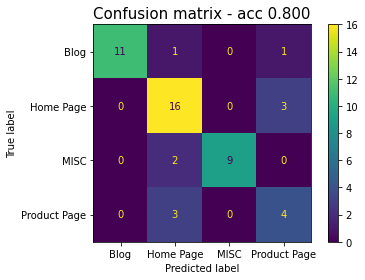


              precision    recall  f1-score   support

        Blog       1.00      0.85      0.92        13
   Home Page       0.73      0.84      0.78        19
        MISC       1.00      0.82      0.90        11
Product Page       0.50      0.57      0.53         7

    accuracy                           0.80        50
   macro avg       0.81      0.77      0.78        50
weighted avg       0.83      0.80      0.81        50



In [73]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced'
                                   ), 
                X_train_, 
                y_train_)

y_val_pred = predict(lr_clf, X_valid_)

print_confusion_matrix(y_val, y_val_pred, with_report=True)

In [68]:
num_labels = len(y_train.value_counts())

In [69]:
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_38']
You should probably TRAIN this model on a down-stream task to be able to use i

In [70]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [71]:
# The column names to convert to TensorFlow tensors
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForTokenClassification
from transformers import DefaultDataCollator


tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 64

# data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
data_collator = DefaultDataCollator(return_tensors="tf")


tf_train_dataset = dataset_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["label"], shuffle=True,
                                                           batch_size=batch_size,
                                                           collate_fn=data_collator
                                                          )
tf_eval_dataset = dataset_encoded["validation"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator
                                                              )

tf_train_dataset

TypeError: ignored

In [ ]:
import tensorflow as tf

# tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                  metrics=tf.metrics.SparseCategoricalAccuracy()
#                  )

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics='accuracy'
                 )

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

In [ ]:
tf.keras.models.save_model(tf_model, filepath='my_model', overwrite=True, save_format='tf')

In [ ]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, eval_accuracy))

In [ ]:
output_logits = tf_model.predict(tf_eval_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)